[INFO] 距離計算 12×12 (UNIT=deg)


C:\Users\flare\AppData\Local\Temp\ipykernel_8964\3212517129.py:170: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_8964\3212517129.py:170: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_8964\3212517129.py:170: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_8964\3212517129.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_8964\3212517129.py:170: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_8964\3212517129.py:170: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from cur

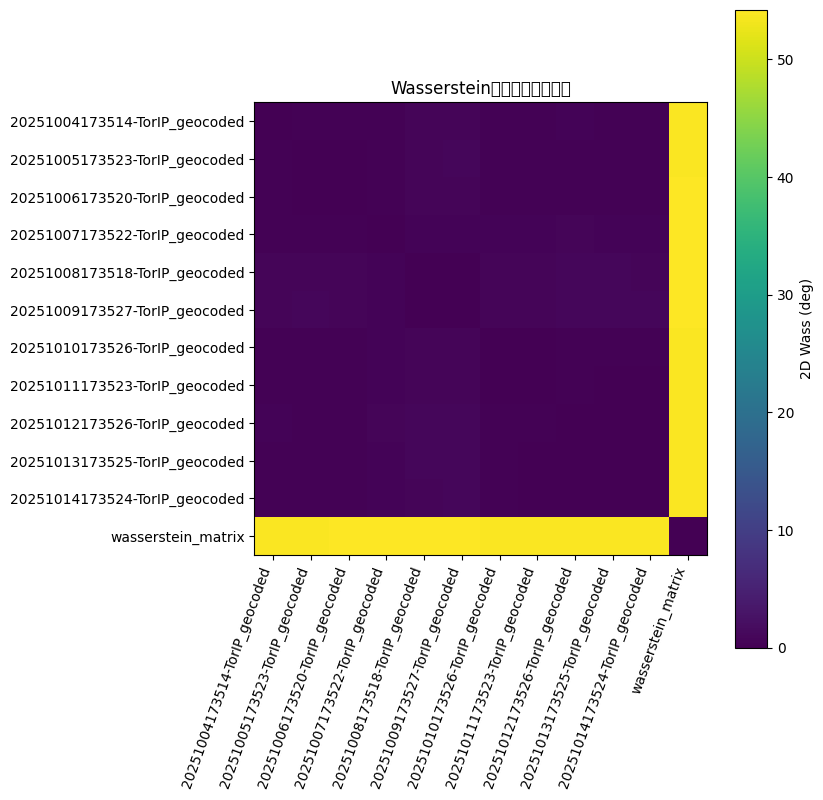

✅ 出力完了
   wasserstein_matrix.csv
   wasserstein_files.txt
   wasserstein_heatmap.png


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
ハードコーディング版：ユーザー引数なし。
カレントディレクトリ内の CSV (ip,timestamp,lat,lng) から
2D Wasserstein距離の行列をCSVとヒートマップPNGで出力する。
"""

# ======= ★ここだけ書き換えれば設定変更できる =======
GLOB_PATTERN = "*.csv"  # 対象CSV
MIN_ROWS = 1            # 各CSVの最小有効行数
PREFIX = "wasserstein"  # 出力ファイル接頭辞
UNIT = "deg"            # "deg" or "km"
# ================================================

import os
import sys
import csv
import glob
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager, rcParams
from scipy.stats import wasserstein_distance

JP_FONT_CANDIDATES = [
    "Noto Sans CJK JP", "Noto Serif CJK JP",
    "IPAexGothic", "IPAPGothic", "TakaoGothic",
]

def setup_japanese_font():
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in JP_FONT_CANDIDATES:
        if name in available:
            rcParams["font.family"] = "sans-serif"
            rcParams["font.sans-serif"] = [name]
            break
    rcParams["axes.unicode_minus"] = False


ENCODINGS = ("utf-8", "utf-8-sig", "cp932")

def open_with_fallback(path):
    for enc in ENCODINGS:
        try:
            return open(path, "r", encoding=enc, newline="")
        except Exception:
            pass
    return open(path, "r")  # 最後の手段: デフォルト


def row_has_header_like(cells):
    if len(cells) < 4:
        return True
    try:
        float(cells[2])
        float(cells[3])
        return False
    except Exception:
        return True


def load_valid_latlon(filepath):
    lats, lons = [], []
    with open_with_fallback(filepath) as f:
        rdr = csv.reader(f)
        first = next(rdr, None)
        if first is None:
            return np.empty(0), np.empty(0)
        use_header = row_has_header_like(first)
        rows_iter = rdr if use_header else [first] + list(rdr)
        for row in rows_iter:
            if len(row) < 4:
                continue
            try:
                lat = float(row[2])
                lon = float(row[3])
                if math.isfinite(lat) and math.isfinite(lon):
                    lats.append(lat)
                    lons.append(lon)
            except Exception:
                continue
    return np.array(lats), np.array(lons)


def deg_to_km_scale(lat_values):
    phi = np.median(lat_values) * math.pi / 180.0 if len(lat_values) else 0.0
    return 111.32, 111.32 * math.cos(phi)


def composite_wasserstein_2d(lat_a, lon_a, lat_b, lon_b):
    if UNIT == "km":
        la_km, lo_km = deg_to_km_scale(np.concatenate([lat_a, lat_b]))
        lat_a, lat_b = lat_a * la_km, lat_b * la_km
        lon_a, lon_b = lon_a * lo_km, lon_b * lo_km
    d_lat = wasserstein_distance(lat_a, lat_b)
    d_lon = wasserstein_distance(lon_a, lon_b)
    return float(np.hypot(d_lat, d_lon))


def main():
    setup_japanese_font()

    files = sorted(glob.glob(GLOB_PATTERN))
    if not files:
        print("[ERROR] CSVが見つかりません:", GLOB_PATTERN, file=sys.stderr)
        return

    lat_data, lon_data = {}, {}
    skipped = []

    for f in files:
        lats, lons = load_valid_latlon(f)
        if len(lats) >= MIN_ROWS and len(lons) >= MIN_ROWS:
            lat_data[f] = lats
            lon_data[f] = lons
        else:
            skipped.append(f"{f}: 有効行不足 lat={len(lats)}, lon={len(lons)}")

    file_list = sorted(lat_data.keys())
    n = len(file_list)

    if n < 2:
        print("[ERROR] 有効なファイルが2つ未満", file=sys.stderr)
        if skipped:
            print("Skipped:", *skipped, sep="\n  ", file=sys.stderr)
        return

    dist = np.zeros((n, n))
    print(f"[INFO] 距離計算 {n}×{n} (UNIT={UNIT})")
    for i in range(n):
        for j in range(i + 1, n):
            d = composite_wasserstein_2d(
                lat_data[file_list[i]], lon_data[file_list[i]],
                lat_data[file_list[j]], lon_data[file_list[j]]
            )
            dist[i, j] = dist[j, i] = d

    # 保存ファイル名
    matrix_csv = f"{PREFIX}_matrix.csv"
    files_txt  = f"{PREFIX}_files.txt"

    # 既存CSV削除（要求）
    if os.path.exists(matrix_csv):
        os.remove(matrix_csv)

    base_names = [os.path.splitext(os.path.basename(f))[0] for f in file_list]

    with open(matrix_csv, "w", encoding="utf-8", newline="") as w:
        wr = csv.writer(w)
        wr.writerow([""] + base_names)
        for i, name in enumerate(base_names):
            wr.writerow([name] + [f"{x:.6f}" for x in dist[i]])

    with open(files_txt, "w", encoding="utf-8") as w:
        w.write("\n".join(file_list))

    fig = plt.figure(figsize=(max(6, n * 0.7), max(5, n * 0.7)))
    ax = plt.gca()
    im = ax.imshow(dist, aspect="equal")
    plt.colorbar(im).set_label(f"2D Wass ({UNIT})")
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(base_names, rotation=70, ha="right")
    ax.set_yticklabels(base_names)
    plt.title("Wasserstein距離ヒートマップ")
    out_png = f"{PREFIX}_heatmap.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()
    plt.close()

    print("✅ 出力完了")
    print("  ", matrix_csv)
    print("  ", files_txt)
    print("  ", out_png)
    if skipped:
        print("⚠ Skipped:", *skipped, sep="\n  ")


if __name__ == "__main__":
    os.remove("./wasserstein_matrix.csv")
    main()
